In [1]:
# !nvidia-smi

In [2]:
# import os
# !pip install -q fastai2 fastcore torch feather-format kornia pyarrow wandb nbdev fastprogress --upgrade 
# !pip install torchvision==0.4.2
# !pip install Pillow==6.2.1 --upgrade
# os._exit(00)

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = Path('/content/gdrive/My Drive/')
root_dir = Path('.')

In [5]:
# !gdown "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

In [6]:
# import zipfile
# with zipfile.ZipFile('cat-dataset.zip', 'r') as zip_ref: zip_ref.extractall()

In [7]:
# source = Path('cats')
source = Path('/home/lgvaz/.data/cats')
fns = get_image_files(source)

In [8]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [9]:
# Remove cropped cats
# fns = L(fn for fn in progress_bar(fns) if (np.array(PILImage.create(fn).size)>get_y(fn)).all() and (get_y(fn)>=0).all())
# len(fns_original) - len(fns)

In [10]:
splits = RandomSplitter(seed=42, valid_pct=0.1)(fns); splits
# splits = (L(range(len(fns))), ()); splits

((#8998) [1303,8607,6679,4255,4697,3769,1697,8715,7247,3845...],
 (#999) [278,5064,9538,9403,2293,8476,4803,7941,2871,7678...])

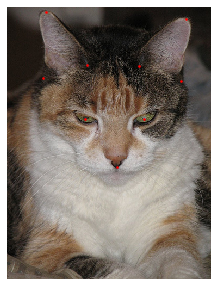

In [11]:
dset = Datasets(fns, tfms=[[PILImage.create], [get_y_fn, get_kpts, TensorPoint.create]], splits=splits)
dset.show(dset[42])

In [12]:
aug_tfms = aug_transforms(do_flip=False)
after_item = [ToTensor(), PointScaler(), Resize(128, method='squish')]
after_batch = [IntToFloatTensor(), *aug_tfms, Normalize.from_stats(*imagenet_stats)]
dl = dset.dataloaders(bs=128, after_item=after_item, after_batch=after_batch)
# dl.show_batch(max_n=5, rows=1)

In [13]:
learn = cnn_learner(dl, resnet34, y_range=(-1.5, 1.5),
                    loss_func=MSELossFlat(), opt_func=ranger, metrics=[MSELossFlat()])
# learn.path = root_dir/'dl/cat_kpts'

In [14]:
# learn.lr_find()

In [15]:
learn.fit_flat_cos(5, 3e-2)

epoch,train_loss,valid_loss,None,time
0,0.345701,0.086524,0.086524,00:36
1,0.156944,0.071699,0.071699,00:35
2,0.104198,0.058295,0.058295,00:36
3,0.082642,0.055346,0.055346,00:35
4,0.075805,0.072678,0.072678,00:35


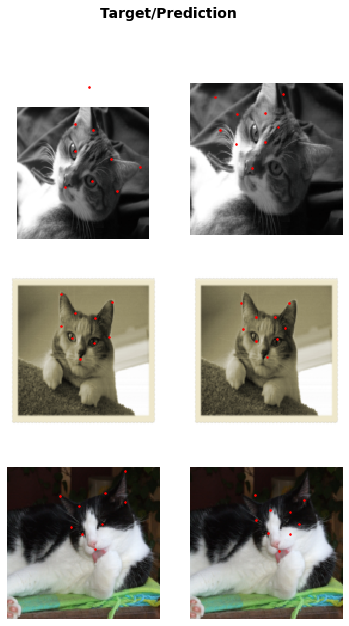

In [17]:
learn.show_results()

In [0]:
learn.save('stage1')

(1.318256749982538e-07, 7.585775847473997e-07)

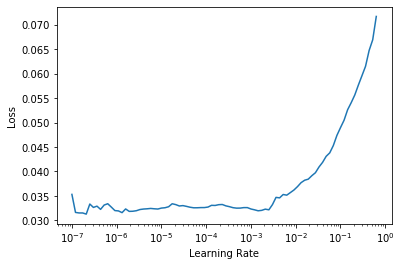

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
# 0.06, 0.04
learn.fit_flat_cos(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,None,time
0,0.031301,0.021553,0.021553,00:40
1,0.031075,0.017479,0.017479,00:40
2,0.028140,0.016565,0.016565,00:41
3,0.027436,0.014548,0.014548,00:39
4,0.026126,0.014677,0.014677,00:40


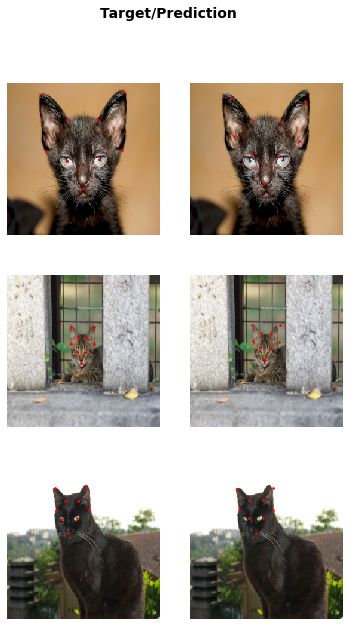

In [21]:
learn.show_results()

In [22]:
learn.save('stage2')
learn.export('stage2')

In [80]:
def predict(learn, item, rm_type_tfms=None, with_input=False):
    dl = learn.dls.test_dl([item], rm_type_tfms=rm_type_tfms)
    inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(learn.dls, 'n_inp', -1) - 1
    dec_inp, full_dec = map(detuplify, learn.dls.decode_batch((*tuplify(inp),*tuplify(dec_preds)))[0][i:])
    res = full_dec,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

In [101]:
im,pt = dset[81]
inp,pred,_,_ = predict(learn, im, with_input=True)

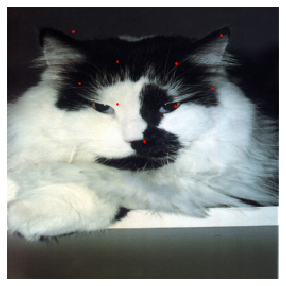

In [102]:
ax = inp.show()
pred.show(ax)

In [116]:
ToTensor??

In [114]:
TensorImage(im).shape

torch.Size([500, 384, 3])

In [115]:
ToTensor()(im).shape

torch.Size([3, 500, 384])